In [1]:
import os 
os.chdir('../')
%pwd

'D:\\projects\\Project-GAN-AnimeFaces'

In [2]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class PrepareModelConfig:
    root_dir: Path
    generator_model: Path
    discriminator_model: Path
    latent_size: int

In [3]:
from AnimeFaces.constants import * 
from AnimeFaces.utils.common import read_yaml, create_directories

In [4]:
class ConfigurationManager:
    def __init__(self , config_filepath = CONFIG_FILE_PATH , params_filepath = PARAMS_FILE_PATH , schema_filepath = SCHEMA_FILE_PATH,):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)
        
        create_directories([self.config.artifacts_root])

    def get_prepare_model_config(self) -> PrepareModelConfig:
        config = self.config.prepare_model
        create_directories([config.root_dir])
        prepare_model_config = PrepareModelConfig(
            root_dir = config.root_dir,
            generator_model = config.generator_model,
            discriminator_model = config.discriminator_model,
            latent_size = config.latent_size,
        )
        return prepare_model_config

In [5]:
from AnimeFaces import logger
from AnimeFaces.utils.device_utils import get_default_device
from AnimeFaces.utils.image_utils import save_samples

In [20]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        self.latent_size = latent_size
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            
            # latent_size x 1 x 1
            nn.ConvTranspose2d(self.latent_size,512,kernel_size=4,stride=1,padding=0,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        
            # 512 x 4 x 4
            nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # 256 x 8 x 8
            nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # 128 x 16 x 16
            nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # 64 x 32 x 32
            nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
            nn.Tanh()
            
            #3 x 64 x 64
        )            
    def forward(self, x):
        return self.model(x)

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # Layer 1: 3 x 64 x 64 -> 64 x 32 x 32
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 2: 64 x 32 x 32 -> 128 x 16 x 16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 3: 128 x 16 x 16 -> 256 x 8 x 8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 4: 256 x 8 x 8 -> 512 x 4 x 4
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 5: 512 x 4 x 4 -> 1 x 1 x 1
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            
            # Flatten for the final layer
            nn.Flatten(),
            
            # Sigmoid activation for binary classification
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [34]:
import torch.nn as nn
import torch
import pickle

class PrepareModel:
    def __init__(self, config: PrepareModelConfig):
        self.config = config
        self.device = get_default_device()
        
    def PrepareDiscriminatorModel(self):
        self.discriminator_model = Discriminator()
        torch.save(self.discriminator_model, self.config.discriminator_model)
    
    def PrepareGeneratorModel(self):
        self.generator_model = Generator(self.config.latent_size)
        torch.save(self.generator_model.state_dict, self.config.generator_model)
        
    def TestGeneratorModel(self, show=True):
        fixed_latent = torch.randn(64,self.config.latent_size,1,1)
        fake_images = self.generator_model(fixed_latent)
        save_samples("TestGeneratorModel",0,fake_images,self.config.root_dir, show)

[2023-10-02 16:13:07,643: INFO: common: yaml file: config\config.yaml loaded successfully]
[2023-10-02 16:13:07,645: INFO: common: yaml file: params.yaml loaded successfully]
[2023-10-02 16:13:07,647: INFO: common: yaml file: schema.yaml loaded successfully]
[2023-10-02 16:13:07,648: INFO: common: Directory Created: artifacts]
[2023-10-02 16:13:07,649: INFO: common: Directory Created: artifacts/prepare_base_model]
[2023-10-02 16:13:07,895: INFO: image_utils: Sample Generated Images Saved: artifacts/prepare_base_model\TestGeneratorModel-0000.png]
True


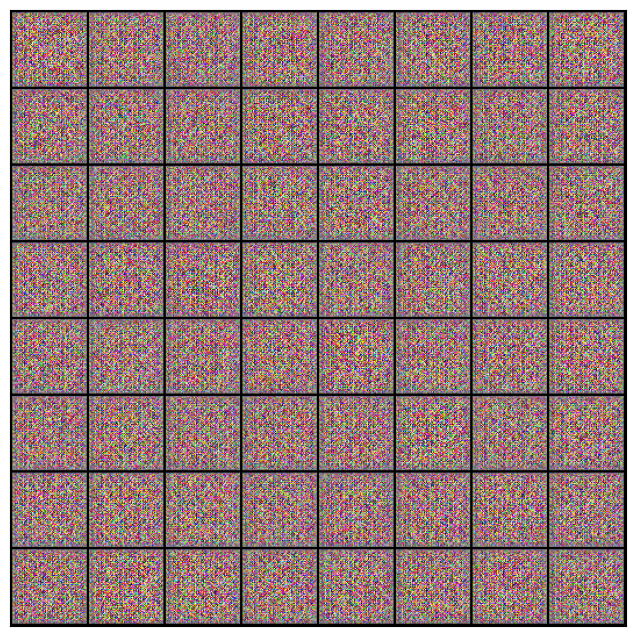

In [35]:
try:
    config = ConfigurationManager()
    prepare_model_config = config.get_prepare_model_config()
    prepare_model = PrepareModel(config = prepare_model_config)
    prepare_model.PrepareDiscriminatorModel()
    prepare_model.PrepareGeneratorModel()
    prepare_model.TestGeneratorModel()
except Exception as e:
    raise e